Although my challenge submission was well-received, I received feedback upon my final draft submission criticizing the lack of exploration between the power output and temperature time series data. As a result, I plotted the relationship between the two time series and fitted a tobit model to the data, regressing power output on the most significant explanatory variable amongst the temperature datasets: temperature_forecast_B.

In [11]:
import pandas as pd
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy
import sklearn
import tensorflow
import pywt
import csv
import pickle
import seaborn as sns

In [7]:
with open("Data/generation.json", "r") as f:
    generation_data = json.load(f)

generation_df = pd.DataFrame(list(generation_data.items()), columns=['timestamp', 'power_output'])

# Convert the original timestamps to datetime format
generation_df['timestamp'] = pd.to_datetime(generation_df['timestamp'])

# Generate new timestamps starting from the first entry and increasing by 15 minutes
new_timestamps = pd.date_range(start=generation_df['timestamp'].iloc[0], 
                               periods=len(generation_df), 
                               freq='15min')

# Replace the original timestamps with the new ones
generation_df['timestamp'] = new_timestamps

# Set the new timestamp as the index
generation_df.set_index('timestamp', inplace=True)

# I apply the natural log transformation to the power output
generation_df['log_power_output'] = np.log(generation_df['power_output'])

# Inspect the transformed data
print(generation_df[['power_output', 'log_power_output']].head())

# I will load, read and parse the XML data
tree = ET.parse("Data/temperatures.xml") 
root = tree.getroot()

# Initialize a dictionary to hold dataframes for each forecast
forecast_dfs = {}

# List of forecast names
forecast_names = ['Forecast A', 'Forecast B', 'Forecast C']

# Loop through each forecast name using nested for loops
for forecast_name in forecast_names:
    forecast_data = []
    for forecast in root.findall(f".//forecast[@name='{forecast_name}']/point"):
        time_forecast_made = forecast.find('time_forecast_made').text
        spot_time = spot_time = pd.to_datetime(forecast.find('spot_time').text) + pd.Timedelta(minutes=1)
        temp_celsius = float(forecast.find('temp_celsius').text)
        
        forecast_data.append({
            f'time_forecast_made_{forecast_name[-1]}': pd.to_datetime(time_forecast_made),
            f'spot_time_{forecast_name[-1]}': pd.to_datetime(spot_time),
            f'temp_celsius_{forecast_name[-1]}': temp_celsius
        })

    # Convert the list to a dataframe and store it in the dictionary
    forecast_dfs[forecast_name] = pd.DataFrame(forecast_data)

# I can access individual dataframes with unique column names
forecast_A_df = forecast_dfs['Forecast A']
forecast_B_df = forecast_dfs['Forecast B']
forecast_C_df = forecast_dfs['Forecast C']

# I can now inspect the dataframes
print(forecast_A_df.head())
print(forecast_B_df.head())
print(forecast_C_df.head())

forecast_A_df.set_index(f'spot_time_A', inplace=True)
forecast_B_df.set_index(f'spot_time_B', inplace=True)
forecast_C_df.set_index(f'spot_time_C', inplace=True)


# Add the temperature columns from each forecast DataFrame to the generation_df
generation_df = generation_df.join(forecast_A_df[f'temp_celsius_A'])
generation_df = generation_df.join(forecast_B_df[f'temp_celsius_B'])
generation_df = generation_df.join(forecast_C_df[f'temp_celsius_C'])

# Inspect the updated generation_df
print(generation_df.head())

from scipy.stats import f

# Here, I define the range of break points 
break_dates = pd.date_range(start='2020-02-01', end='2020-04-30', freq='D')

# Using a dictionary to store the F-statistics
chow_stats = {}

# Looping through each potential break date in our range of break points
for break_date in break_dates:
    # Splitting data into pre-break and post-break datasets
    pre_break_df = generation_df[generation_df.index < break_date]
    post_break_df = generation_df[generation_df.index >= break_date]
    
    # Preparing data for regression
    X_pre = sm.add_constant(np.arange(len(pre_break_df)))
    y_pre = pre_break_df['log_power_output']

    X_post = sm.add_constant(np.arange(len(post_break_df)))
    y_post = post_break_df['log_power_output']

    # Fiting regression models to the data
    model_pre = sm.OLS(y_pre, X_pre).fit()
    model_post = sm.OLS(y_post, X_post).fit()

    # Combining datasets for a full model
    X_full = sm.add_constant(np.arange(len(generation_df)))
    y_full = generation_df['log_power_output']
    model_full = sm.OLS(y_full, X_full).fit()

    # Here, for purposes of calculating the Chow(F)-statistic, I compute the sum of squared residuals for each model
    ssr_full = np.sum(model_full.resid ** 2)
    ssr_pre = np.sum(model_pre.resid ** 2)
    ssr_post = np.sum(model_post.resid ** 2)

    # Number of observations in each segment
    n_pre = len(pre_break_df)
    n_post = len(post_break_df)
    n_total = n_pre + n_post

    # The number of parameters (intercept and slope because this is SLR)
    k = 2

    # Calculate the Chow Test F-statistic
    F_chow = ((ssr_full - (ssr_pre + ssr_post)) / k) / ((ssr_pre + ssr_post) / (n_total - 2 * k))
    
    # Store the Chow(F)-statistic with the corresponding date
    chow_stats[break_date] = F_chow

# Choosing the date with the maximum Chow(F)-statistic
max_break_date = max(chow_stats, key=chow_stats.get)
max_f_stat = chow_stats[max_break_date]

print(f'Maximum Chow Test F-statistic: {max_f_stat} on {max_break_date}')

# Calling the break date from the earlier Chow test result
break_date = max_break_date  

# Separating the data into pre-break and post-break periods
pre_break_df = generation_df[generation_df.index < break_date]
post_break_df = generation_df[generation_df.index >= break_date]

# Calculating the range of the log power output for pre-break and post-break datasets
pre_break_range = pre_break_df['log_power_output'].max() - pre_break_df['log_power_output'].min()
post_break_range = post_break_df['log_power_output'].max() - post_break_df['log_power_output'].min()

# Calculating the shift amount needed to match the ranges
shift_amount = post_break_df['log_power_output'].min() - pre_break_df['log_power_output'].min()
scale_factor = post_break_range / pre_break_range # Just to be sure the ranges are the same and it makes sense to do this transformation

# Applying the scaling and shift to the pre-break data
pre_break_df['log_power_output_shifted'] = pre_break_df['log_power_output'] * scale_factor + shift_amount

# Combine the shifted pre-break data with the original post-break data
combined_df = pd.concat([pre_break_df[['log_power_output_shifted']], post_break_df[['log_power_output']]])
combined_df.rename(columns={'log_power_output_shifted': 'log_power_output'}, inplace=True)

# Renaming the columns for clarity
combined_df.columns = ['log_power_output_pre_break', 'log_power_output_post_break']

# Combining the columns to fill NaNs in pre-break data with post-break data as mentioned
combined_df['log_power_output'] = combined_df['log_power_output_pre_break'].combine_first(combined_df['log_power_output_post_break'])

# I can now drop the unnecessary pre-break and post-break columns
combined_df = combined_df.drop(columns=['log_power_output_pre_break', 'log_power_output_post_break'])

generation_df = generation_df.loc[combined_df.index]

# Adding the temperature forecast columns to the combined_df
combined_df['temp_celsius_A'] = generation_df['temp_celsius_A']
combined_df['temp_celsius_B'] = generation_df['temp_celsius_B']
combined_df['temp_celsius_C'] = generation_df['temp_celsius_C']

# View the new master table
combined_df


                     power_output  log_power_output
timestamp                                          
2018-01-01 00:01:00          10.0          2.302585
2018-01-01 00:16:00          10.0          2.302585
2018-01-01 00:31:00          10.0          2.302585
2018-01-01 00:46:00          10.0          2.302585
2018-01-01 01:01:00          10.0          2.302585
  time_forecast_made_A         spot_time_A  temp_celsius_A
0  2018-01-01 00:30:00 2018-01-01 00:01:00       10.068520
1  2018-01-01 00:45:00 2018-01-01 00:16:00        7.283149
2  2018-01-01 01:00:00 2018-01-01 00:31:00        8.149209
3  2018-01-01 01:15:00 2018-01-01 00:46:00        6.826715
4  2018-01-01 01:30:00 2018-01-01 01:01:00        9.949895
  time_forecast_made_B         spot_time_B  temp_celsius_B
0  2017-12-31 18:00:00 2018-01-01 00:01:00        9.043016
1  2017-12-31 18:15:00 2018-01-01 00:16:00        8.069365
2  2017-12-31 18:30:00 2018-01-01 00:31:00        7.951525
3  2017-12-31 18:45:00 2018-01-01 00:46:00    

C:\Users\jason\AppData\Local\Temp\ipykernel_4452\549653875.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_break_df['log_power_output_shifted'] = pre_break_df['log_power_output'] * scale_factor + shift_amount


,log_power_output,temp_celsius_A,temp_celsius_B,temp_celsius_C
timestamp,,,,
2018-01-01 00:01:00,2.862201,10.068520,9.043016,11.041315
2018-01-01 00:16:00,2.862201,7.283149,8.069365,9.853585
2018-01-01 00:31:00,2.862201,8.149209,7.951525,10.753473
2018-01-01 00:46:00,2.862201,6.826715,8.583614,10.306547
2018-01-01 01:01:00,2.862201,9.949895,9.238085,10.521315
...,...,...,...,...
2022-05-31 22:46:00,4.466433,21.946381,21.308607,23.271850
2022-05-31 23:01:00,4.276889,20.849525,20.597889,23.586474
2022-05-31 23:16:00,3.709090,17.472524,17.821313,20.203671


**Tobit Model Test**

C:\Users\jason\AppData\Local\Temp\ipykernel_4452\3154260475.py:21: RuntimeWarning: divide by zero encountered in log
  llf_upper_censored = np.log(1 - norm.cdf((right - y_hat) / sigma))
C:\Users\jason\AppData\Local\Temp\ipykernel_4452\3154260475.py:18: RuntimeWarning: divide by zero encountered in log
  llf_lower_censored = np.log(norm.cdf((left - y_hat) / sigma))
c:\Users\jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\jason\AppData\Local\Temp\ipykernel_4452\3154260475.py:18: RuntimeWarning: divide by zero encountered in log
  llf_lower_censored = np.log(norm.cdf((left - y_hat) / sigma))
C:\Users\jason\AppData\Local\Temp\ipykernel_4452\3154260475.py:21: RuntimeWarning: divide by zero encountered in log
  llf_upper_censored = np.log(1 - norm.cdf((right - y_hat) / sigma))
C:\Users\jason\AppData\Local\Temp\ipykernel_4452\3154260475.py:21: RuntimeWarning: divid

Beta Estimates: [0.25455171 0.19758864]
Sigma Estimate: 0.7313533663956051


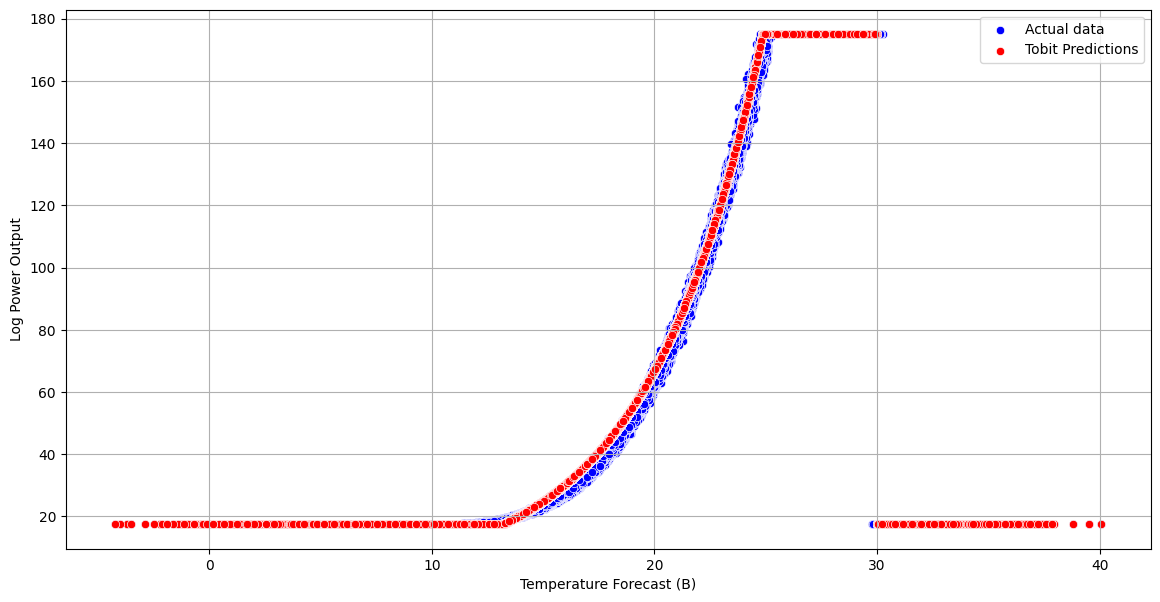

In [17]:
from scipy.optimize import minimize
from scipy.stats import norm

# Weighted log-likelihood function for Tobit model
def tobit_loglike(params, X, y, left, right, weight):
    beta = params[:-1]  # Coefficients for the model
    sigma = params[-1]  # Standard deviation of the error term

    y_hat = np.dot(X, beta)  # Predicted values
    uncensored = (y > left) & (y < right)  # Indicator for uncensored observations
    censored_lower = y <= left  # Indicator for left-censored observations
    censored_upper = y >= right  # Indicator for right-censored observations

    # Log-likelihood for uncensored observations
    llf_uncensored = np.log(1 / (np.sqrt(2 * np.pi) * sigma)) - 0.5 * (((y - y_hat) / sigma) ** 2)

    # Log-likelihood for lower-censored observations
    llf_lower_censored = np.log(norm.cdf((left - y_hat) / sigma))

    # Log-likelihood for upper-censored observations
    llf_upper_censored = np.log(1 - norm.cdf((right - y_hat) / sigma))

    # Weight the uncensored part more heavily
    llf = np.zeros_like(y)
    llf[uncensored] = llf_uncensored[uncensored] * weight
    llf[censored_lower] = llf_lower_censored[censored_lower] * weight * 4
    llf[censored_upper] = llf_upper_censored[censored_upper] * weight * 12

    # Return the negative log-likelihood (since we're using a minimizer)
    return -np.sum(llf)

# Tobit regression function with weighted uncensored observations
def fit_tobit_model(X, y, left, right, weight):
    # Initial guess for the parameters (OLS estimates + initial sigma guess)
    ols_model = sm.OLS(y, X).fit()
    initial_params = np.append(ols_model.params, np.std(ols_model.resid))

    # Minimize the negative log-likelihood function
    result = minimize(tobit_loglike, initial_params, args=(X, y, left, right, weight), method='BFGS')

    # Extract the estimated parameters
    beta_estimates = result.x[:-1]  # Coefficients
    sigma_estimate = result.x[-1]  # Standard deviation of the residuals

    return beta_estimates, sigma_estimate

# Define your X and y variables (input features and log_power_output)
X = sm.add_constant(combined_df['temp_celsius_B'])  # Adding constant for the intercept
y = combined_df['log_power_output']

# Define censoring bounds
censoring_bound_lower = y.min()  # Replace with appropriate bounds for your case
censoring_bound_upper = y.max()

# Fit the Tobit model with increased weight for uncensored observations
weight = 1.0  # Increase the weight to focus more on the uncensored region
beta_estimates, sigma_estimate = fit_tobit_model(X, y, censoring_bound_lower, censoring_bound_upper, weight=weight)

print("Beta Estimates:", beta_estimates)
print("Sigma Estimate:", sigma_estimate)

# Make predictions using the fitted model
y_pred = np.dot(X, beta_estimates)

# Apply censoring to predictions (Tobit adjustment)
y_pred_adjusted = np.clip(y_pred, censoring_bound_lower, censoring_bound_upper)

temperature_threshold = 30.0
y_pred_adjusted[combined_df['temp_celsius_B'] >= temperature_threshold] = censoring_bound_lower

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
sns.scatterplot(x=combined_df['temp_celsius_B'], y=np.exp(y), color='blue', label='Actual data')
sns.scatterplot(x=combined_df['temp_celsius_B'], y=np.exp(y_pred_adjusted), color='red', label='Tobit Predictions')
plt.xlabel('Temperature Forecast (B)')
plt.ylabel('Log Power Output')
plt.legend()
plt.grid(True)
plt.show()
